In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<img src="./images/nvmath_head_panel@0.5x.png" alt="nvmath-python" />

# Getting Started with nvmath-python: Device APIs

## Overview

This notebook introduces **nvmath-python**'s device APIs, which enable the use of high-performance mathematical functions directly within custom CUDA kernels written with Numba CUDA. This powerful capability allows you to combine custom logic with optimized library functions in a single kernel, dramatically improving performance for complex algorithms.

**Learning Objectives:**
* Understand what device APIs are and how they differ from host APIs
* Use `nvmath.device.random` for random number generation within custom CUDA kernels
* Write custom CUDA kernels using Numba CUDA that incorporate **nvmath-python** device functions
* Apply device APIs to implement Monte Carlo simulations (Geometric Brownian Motion)
* Visualize stochastic processes including Arithmetic and Geometric Brownian Motion
* Benchmark performance improvements from kernel fusion using device APIs
* Optimize random number generation by consuming multiple variates per iteration

---
## Introduction

Device APIs in **nvmath-python** allow you to call mathematical functions directly from within custom CUDA kernels. This is fundamentally different from the host APIs we've used in previous notebooks, which are called from Python code and launch GPU kernels internally.

**Key Advantages of Device APIs:**
1. **Kernel Fusion**: Combine custom logic with library functions in a single kernel, eliminating intermediate memory operations
2. **Flexibility**: Implement complex algorithms that aren't directly expressible with host-level APIs
3. **Performance**: Reduce kernel launch overhead and memory bandwidth requirements
4. **Integration**: Seamlessly integrate with existing [Numba CUDA](https://numba.readthedocs.io/en/stable/cuda/index.html) code

This notebook demonstrates device APIs through a computational mathematics example: Monte Carlo simulation of stock prices using the *Geometric Brownian Motion* (GBM) model. We'll use `nvmath.device.random` to generate random numbers directly within a custom CUDA kernel that computes the entire simulation path.

**Prerequisites:** To use this notebook, you will need:
- A computer equipped with an NVIDIA GPU
- Completion of previous notebooks (recommended)
- Understanding of Numba CUDA and basic CUDA programming concepts
- Familiarity with stochastic processes (helpful but not required)

For detailed installation instructions, please refer to the [nvmath-python documentation](https://docs.nvidia.com/cuda/nvmath-python/latest/installation.html#install-nvmath-python).

---
## Setup

This notebook uses the same benchmarking helper function from previous notebooks:

In [ ]:
import numpy as np
import cupyx as cpx


# Helper function to benchmark two implementations F and (optionally) F_alternative
# When F_alternative is provided, in addition to raw performance numbers (seconds)
# speedup of F relative to F_alternative is reported
def benchmark(
    F, F_name="Implementation", F_alternative=None, F_alternative_name="Alternative implementation", n_repeat=10, n_warmup=1
):
    # warm-up + repeated runs
    timing = cpx.profiler.benchmark(F, n_repeat=n_repeat, n_warmup=n_warmup)
    # best time from repeated runs
    perf = np.min(timing.gpu_times)
    print(f"{F_name} performance = {perf:0.4f} sec")

    if F_alternative is not None:
        timing_alt = cpx.profiler.benchmark(F_alternative, n_repeat=n_repeat, n_warmup=n_warmup)
        perf_alt = np.min(timing_alt.gpu_times)
        print(f"{F_alternative_name} performance = {perf_alt:0.4f} sec")
        print(f"Speedup = {perf_alt / perf:0.4f}x")
    else:
        perf_alt = None

    return perf, perf_alt

---
## Background: Stochastic Processes

Before diving into the implementation, let's review the mathematical concepts we'll be using.

### Arithmetic Brownian Motion

*Arithmetic Brownian motion* (also called *simple Brownian motion* or the *Wiener process*) is one of the most important stochastic processes in mathematics and finance.

In its normalized form, the process $ B_t $ has the following properties:

1. **Initial Condition**: $ B_0 = 0 $
2. **Normal Increments**: At any two time moments $ t $ and $ s $ where $ t > s $, the increment $ B_t - B_s $ is normally distributed:
   \[ B_t - B_s \sim \mathcal{N}(0, t-s) \]
3. **Independent Increments**: Any two non-overlapping increments are independent
4. **Continuous Paths**: The process has continuous sample paths

The process evolves from $ t = 0 $ to $ t = T $ with zero mean and standard deviation $ \sqrt{T} $.

Let's visualize a sample of Brownian motion paths using [NumPy](https://numpy.org/):

In [ ]:
def brownian_motion(nsteps, npaths):
    dBt = np.random.randn(npaths, nsteps - 1)
    dBt = np.insert(dBt, 0, 0.0, axis=1)  # The process starts at 0
    Bt = np.cumsum(dBt, axis=1)
    return Bt


RNG_SEED = 77777  # Random seed
N_STEPS = 100  # Number of time steps
N_PATHS = 500  # Number of simulated paths

np.random.seed(RNG_SEED)
paths = brownian_motion(N_STEPS, N_PATHS)
t = np.arange(N_STEPS)

The plot below shows multiple sample paths of Brownian motion, along with theoretical bounds at \( \pm\sqrt{t} \), \( \pm 2\sqrt{t} \), and \( \pm 3\sqrt{t} \):

In [ ]:
from matplotlib import pyplot as plt
import math
from scipy.stats import norm

LIGHT_GREY = "#AAA"
GREY = "#777"
BLACK = "#000"
PRIMARY_GREEN = "#76B900"
DARK_GREEN = "#619900"

fig = plt.figure(figsize=(13, 6))
ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=3)

ax0.grid(True, linestyle="--")
ax0.axvline(x=0, color="k")
for i in range(1, paths.shape[0]):
    ax0.plot(t, paths[i], color=PRIMARY_GREEN, linewidth=1)
ax0.plot(t, paths[0], color=DARK_GREEN, linewidth=2)
ax0.plot(t, np.sqrt(t), color=BLACK, linestyle=":", linewidth=2)
ax0.plot(t, -np.sqrt(t), color=BLACK, linestyle=":", linewidth=2)
ax0.plot(t, 2 * np.sqrt(t), color=BLACK, linestyle=":", linewidth=2)
ax0.plot(t, -2 * np.sqrt(t), color=BLACK, linestyle=":", linewidth=2)
ax0.plot(t, 3 * np.sqrt(t), color=BLACK, linestyle=":", linewidth=2)
ax0.plot(t, -3 * np.sqrt(t), color=BLACK, linestyle=":", linewidth=2)
ax0.annotate(r"$\sqrt{t}$", xy=(50, 9), fontsize=16, fontweight="bold", rotation=6, ha="center", va="center")
ax0.annotate(r"$2\sqrt{t}$", xy=(50, 16), fontsize=16, fontweight="bold", rotation=10, ha="center", va="center")
ax0.annotate(r"$3\sqrt{t}$", xy=(50, 24), fontsize=16, fontweight="bold", rotation=12, ha="center", va="center")
ax0.set_xlabel("Time Steps")
ax0.set_title("Brownian motion")
ax0.axis("on")
ax0.set_ylim(-30, 30)

x = np.linspace(-30, 30)
ax1 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax1.hist(paths[:, -1], bins=29, density=True, orientation="horizontal", color=PRIMARY_GREEN, edgecolor=DARK_GREEN)
ax1.plot(norm.pdf(x, loc=0, scale=math.sqrt(N_STEPS)), x, color=BLACK)
ax1.set_ylim(-30, 30)
ax1.get_yaxis().set_visible(False)
ax1.set_title(f"Histogram at $t={N_STEPS}$")
ax1.annotate(r"$\mathcal{N}{\left(0, t\right)}$", xy=(0.04, 0), va="center", rotation=-90, fontsize=16)

plt.show()

---
## Geometric Brownian Motion

Geometric Brownian Motion (GBM) is a continuous-time stochastic process derived from arithmetic Brownian motion. It is particularly useful for modeling non-negative quantities that grow exponentially over time, such as stock prices.

**Mathematical Definition:**

The GBM process $ S_t $ is defined as:

$$
S_t = S_0 \exp \left(\left( \mu - \frac{\sigma^2}{2} \right) t + \sigma B_t \right)
$$

where:
- $ S_0 $ is the initial value (e.g., initial stock price)
- $ \mu $ is the *drift* parameter (expected return rate)
- $ \sigma $ is the *volatility* parameter (measure of randomness)
- $ B_t $ is a standard Brownian motion

**Differential Form:**

It is often more convenient to express GBM in differential form using a stochastic differential equation (SDE):

$$
dS_t = \mu S_t dt + \sigma S_t dB_t
$$

**Properties:**
- Starts at $ S_0 $ (unlike simple Brownian motion which starts at $ 0 $)
- Never goes below $ 0 $ (log-normal distribution)
- Commonly used as a first-order approximation for stock price dynamics
- Used extensively in options pricing (Black-Scholes model)

Let's implement and visualize GBM:

In [ ]:
S0 = 100.0  # Initial stock price
MU = 0.003
SIGMA = 0.027

RNG_SEED = 77777  # Random seed
N_STEPS = 252  # Number of time steps
N_PATHS = 500  # Number of simulated paths


def brownian_motion(nsteps, npaths, mu, sigma):
    # Differential form of the Brownian motion
    dBt = np.random.randn(npaths, nsteps - 1) * sigma + mu
    dBt = np.insert(dBt, 0, 0.0, axis=1)  # The process starts at 0

    # Integral form of the Brownian motion
    Bt = np.cumsum(dBt, axis=1)

    return Bt


np.random.seed(RNG_SEED)
b_t = brownian_motion(N_STEPS, N_PATHS, MU, SIGMA)
s_t = S0 * np.exp(b_t)

print(f"Mean stock price at t=T: {s_t[:, -1].mean():0.2f}")
print(f"Standard deviation of stock price at t=T: {s_t[:, -1].std():0.2f}")

The plot below shows sample paths of stock prices following Geometric Brownian Motion:

In [ ]:
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(111)
ax.grid(True, linestyle='--', alpha=0.7)
for i in range(1, s_t.shape[0]):
    ax.plot(s_t[i], color=PRIMARY_GREEN, linewidth=1)
ax.plot(s_t[0], color=DARK_GREEN, linewidth=2)
ax.set_title("Stock price simulated as GBM")
ax.set_xlabel("Time Steps")
ax.set_ylabel("Stock Price")
plt.show()

---
## GPU Implementation with CuPy

Now let's create a GPU-accelerated version using [CuPy](https://cupy.dev/). This implementation uses array operations similar to the NumPy version but executes on the GPU:

In [ ]:
import nvmath
import cupy as cp

RNG_SEED = 777777  # Random seed
N_STEPS = 252  # Number of time steps (trading days in a year)
N_PATHS = 800000  # Number of simulated paths (large number to get a reliable estimate)

S0 = 100.0  # Initial stock price
MU = 0.003  # Drift with upward trend
SIGMA = 0.027  # Volatility


def brownian_motion(nsteps, npaths, mu, sigma):
    # Differential form of the Brownian motion
    dBt = cp.empty((npaths, nsteps), dtype=cp.float32, order="F")
    dBt[:, 0] = 0.0  # The process starts at 0
    dBt[:, 1:] = cp.random.randn(npaths, nsteps - 1) * sigma + mu

    # Integral form of the Brownian motion
    Bt = cp.cumsum(dBt, axis=1)

    return Bt


def generate_gbm_paths_cupy(npaths, nsteps, mu, sigma, s0):
    b_t = brownian_motion(nsteps, npaths, mu, sigma)
    paths = s0 * cp.exp(b_t)
    return paths


cp.random.seed(RNG_SEED)
s_t = generate_gbm_paths_cupy(N_PATHS, N_STEPS, MU, SIGMA, S0)

print(f"Mean stock price at t=T: {s_t[:, -1].mean():0.2f}")
print(f"Standard deviation of stock price at t=T: {s_t[:, -1].std():0.2f}")
print(type(s_t))

### Performance Analysis of CuPy Implementation

The CuPy implementation above consists of a chain of primitive operations with very low arithmetic intensity. Each primitive operation processes an array of shape `(N_PATHS, N_STEPS)`, which makes the overall workload heavily memory-bound:

1. Random number generation creates a large array
2. Cumulative sum creates another large intermediate array
3. Exponential operation reads and writes the full array

**Optimization Strategy:**

To improve arithmetic intensity and reduce memory bandwidth requirements, we can implement a custom CUDA kernel using Numba CUDA. In this approach:
- Each GPU thread handles an entire Monte Carlo path from $ t=0 $ to $ t=T $
- Random numbers are generated on-the-fly as needed, not stored in memory
- The total number of threads equals `N_PATHS`
- No intermediate arrays are allocated

---
## Device API Implementation with nvmath-python

The **nvmath-python** library provides device APIs for *random number generation* that can be used within Numba CUDA kernels for efficient on-device random number generation. The following code illustrates the implementation of GBM using Numba CUDA and `nvmath.device.random`:

In [ ]:
from numba import cuda
from nvmath.device import random
import cupy as cp

RNG_SEED = 777777  # Random seed
N_STEPS = 252  # Number of time steps (trading days in a year)
N_PATHS = 800000  # Number of simulated paths (large number to get a reliable estimate)

S0 = 100.0  # Initial stock price
MU = 0.003  # Drift with upward trend
SIGMA = 0.027  # Volatility

# Pre-compile the random number generator into IR to use alongside other device code
compiled_rng = random.Compile(cc=None)

# Set up CUDA kernel launch configuration
threads_per_block = 32
blocks = N_PATHS // threads_per_block
nthreads = threads_per_block * blocks + bool(N_PATHS % threads_per_block)
print(f"blocks: {blocks}, threads_per_block: {threads_per_block}, nthreads: {nthreads}")

# Allocate space for random states
states = random.StatesPhilox4_32_10(nthreads)


# RNG initialization kernel
@cuda.jit(link=compiled_rng.files, extensions=compiled_rng.extension)
def init_rng_gpu(states, seed):
    idx = cuda.grid(1)
    random.init(seed, idx, 0, states[idx])


# GBM path generation kernel. Note that the random numbers are generated
# as they are needed, unlike for the NumPy/CuPy implementation where they are
# generated upfront and stored.
@cuda.jit(link=compiled_rng.files, extensions=compiled_rng.extension)
def generate_gbm_paths_nvmath(states, paths, nsteps, mu, sigma, s0):
    mu = paths.dtype.type(mu)
    sigma = paths.dtype.type(sigma)
    s0 = paths.dtype.type(s0)

    # Get the thread index
    idx = cuda.grid(1)

    # If the thread index is out of bounds, return
    if idx >= paths.shape[0]:
        return

    # Each thread generates one path in the time domain
    paths[idx, 0] = s0

    # Consume a single normal variate at a time
    for i in range(1, nsteps):
        z = random.normal(states[idx])
        z = mu + sigma * z
        paths[idx, i] = paths[idx, i - 1] * math.exp(z)


# Allocate space for paths
paths_gpu = cp.empty((N_PATHS, N_STEPS), dtype=cp.float32)

# Initialize RNG states
init_rng_gpu[blocks, threads_per_block](states, RNG_SEED)

# Generate GBM paths on GPU
generate_gbm_paths_nvmath[blocks, threads_per_block](states, paths_gpu, N_STEPS, MU, SIGMA, S0)

print(f"Mean stock price at t=T: {paths_gpu[:, -1].mean():0.2f}")
print(f"Standard deviation of stock price at t=T: {paths_gpu[:, -1].std():0.2f}")

### Performance Benchmarking

Now let's benchmark the **nvmath-python** device API implementation and compare it to the CuPy implementation:

In [ ]:
benchmark(
    lambda: generate_gbm_paths_nvmath[blocks, threads_per_block](states, paths_gpu, N_STEPS, MU, SIGMA, S0),
    "nvmath-python",
    lambda: generate_gbm_paths_cupy(N_PATHS, N_STEPS, MU, SIGMA, S0),
    "CuPy",
    n_repeat=5,
    n_warmup=1,
)

### Optimization: Vectorized Random Number Generation

Major performance inefficiency in the above implementation is the layout of `paths_gpu`. For best performance, paths at each time step should exhibit thread block locality, whereas in the above implementation they are contiguous in time.

Further kernel optimization will leverage the fact that the Philox4_32_10 random number generator returns 4 variates at a time. This allows us to produce 4 time steps in a single loop iteration, reducing the number of RNG calls.

**Key Optimization:**
- Re-arrange `paths_gpu` to exhibit thread block locality by using Fortran (column) order layout
- Use `random.normal4()` instead of `random.normal()` to get 4 random numbers at once
- Process 4 time steps per loop iteration
- To avoid unnecessary type conversions at each time step, ensure GBM parameters' type is aligned with `paths_gpu.dtype`

In [ ]:
from numba import cuda
from nvmath.device import random
import cupy as cp

RNG_SEED = 777777  # Random seed
N_STEPS = 252  # Number of time steps (trading days in a year)
N_PATHS = 800000  # Number of simulated paths (large number to get a reliable estimate)

S0 = 100.0  # Initial stock price
MU = 0.003  # Drift with upward trend
SIGMA = 0.027  # Volatility

# Pre-compile the random number generator into IR to use alongside other device code
compiled_rng = random.Compile(cc=None)

# Set up CUDA kernel launch configuration
threads_per_block = 32
blocks = N_PATHS // threads_per_block
nthreads = threads_per_block * blocks + bool(N_PATHS % threads_per_block)
print(f"blocks: {blocks}, threads_per_block: {threads_per_block}, nthreads: {nthreads}")

# Allocate space for random states
states = random.StatesPhilox4_32_10(nthreads)


# RNG initialization kernel
@cuda.jit(link=compiled_rng.files, extensions=compiled_rng.extension)
def init_rng_gpu(states, seed):
    idx = cuda.grid(1)
    random.init(seed, idx, 0, states[idx])


@cuda.jit(link=compiled_rng.files, extensions=compiled_rng.extension)
def generate_gbm_paths_gpu(states, paths, nsteps, mu, sigma, s0):
    # Make sure the parameters are aligned with the paths array dtype
    mu = paths.dtype.type(mu)
    sigma = paths.dtype.type(sigma)
    s0 = paths.dtype.type(s0)

    # Get the thread index
    idx = cuda.grid(1)

    # If the thread index is out of bounds, return
    if idx >= paths.shape[0]:
        return

    # Each thread generates one path in the time domain
    paths[idx, 0] = s0

    # Consume 4 normal variates at a time for better throughput
    for i in range(1, nsteps, 4):
        v = random.normal4(states[idx])  # Returned as float32x4 type
        vals = v.x, v.y, v.z, v.w  # Decompose into a tuple of float32
        # Process a chunk of 4 time steps, use min() to avoid out-of-bounds access
        for j in range(i, min(i + 4, nsteps)):
            paths[idx, j] = paths[idx, j - 1] * math.exp(mu + sigma * vals[j - i])


# Allocate space for paths
paths_gpu = cp.empty((N_PATHS, N_STEPS), dtype=cp.float32, order="F")

# Initialize RNG states
init_rng_gpu[blocks, threads_per_block](states, RNG_SEED)

# Generate GBM paths on GPU
generate_gbm_paths_nvmath[blocks, threads_per_block](states, paths_gpu, N_STEPS, MU, SIGMA, S0)

print(f"Mean stock price at t=T: {paths_gpu[:, -1].mean():0.2f}")
print(f"Standard deviation of stock price at t=T: {paths_gpu[:, -1].std():0.2f}")

In [ ]:
benchmark(
    lambda: generate_gbm_paths_nvmath[blocks, threads_per_block](states, paths_gpu, N_STEPS, MU, SIGMA, S0),
    "nvmath-python",
    lambda: generate_gbm_paths_cupy(N_PATHS, N_STEPS, MU, SIGMA, S0),
    "CuPy",
    n_repeat=5,
    n_warmup=1,
)

## Exercise: Implement numba-cuda kernel for Monte Carlo simulation of American Option call and put option cashflows

In this exercise you will do the following:
1. Familiarize yourself with the definitions of the call and put American options.
2. Take GBM implementation as a baseline for implementing call/put cashflows simulation. Additionally use the CuPy implementation below as a reference implementation of the entire workflow. 
3. Compare nvmath-python/numba-cuda vs. CuPy implementations for correctness. 
4. Benchmark nvmath-python/numba-cuda implementation vs. CuPy and explain the performance difference 

### American Options: Call and Put Definitions

**American Call Option:**
An American call option gives the holder the **right, but not the obligation**, to **buy** an underlying asset (such as a stock) at a predetermined strike price **at any time before or on the expiration date** `T`. The key feature that distinguishes American options from European options is this ability to exercise early. The holder profits when the asset price exceeds the strike price, with the payoff being `max(S - K, 0) - Premium`, where `S` is the spot price, `K` is the strike price, and `Premium` is the initial cost paid for the option.

**American Put Option:**
An American put option gives the holder the **right, but not the obligation**, to **sell** an underlying asset at a predetermined strike price **at any time before or on the expiration date** `T`. Similar to the call option, it can be exercised at any point during its lifetime. The holder profits when the asset price falls below the strike price, with the payoff being `max(K - S, 0) - Premium`.

**Key Characteristics:**
- **Flexibility**: Can be exercised at any time up to expiration (unlike European options which can only be exercised at expiration)
- **Premium**: The upfront cost paid to acquire the option
- **Strike Price**: The predetermined price at which the transaction can occur
- **Intrinsic Value**: The immediate profit if exercised now (can be zero if out-of-the-money)
- **Time Value**: Additional value due to the possibility of favorable price movements before expiration


The following charts illustrate call and put option *payoff functions* relative to the spot price `S`. Note horizontal negative areas representing the fact that the holder has the right to quit without exercising the contract with a small penalty, which is equal to `Premium`.

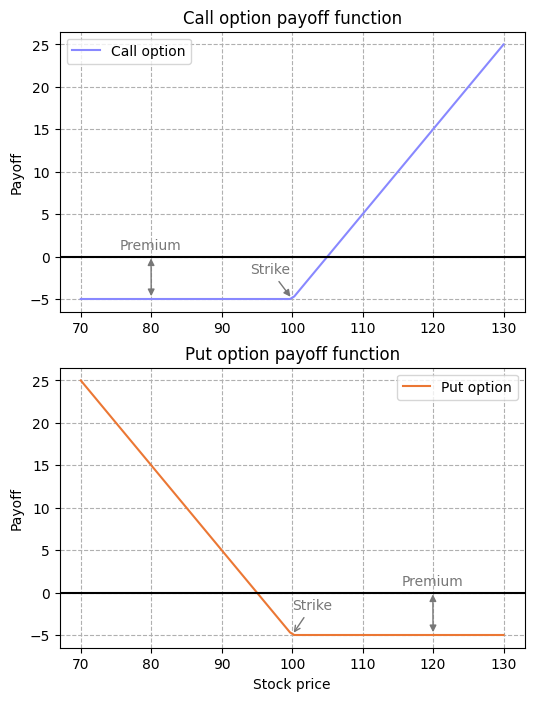

In [12]:
LIGHT_GREY = "#AAA"
GREY = "#777"
BLACK = "#000"
PRIMARY_GREEN = "#76B900"
DARK_GREEN = "#619900"
PRIMARY_BLUE = '#88f'
DARK_BLUE = '#55a'
PRIMARY_RED = '#eb7734'
DARK_RED = '#ba5012'

import numpy as np
import matplotlib.pyplot as plt

def call_payoff(x, strike, premium):
    return np.maximum(x - strike, 0.0) - premium

def put_payoff(x, strike, premium):
    return np.maximum(strike - x, 0.0) - premium


strike_price = 100.0
premium = 5.0
stock_price = np.linspace(70.0, 130.0, 100)
cpay = call_payoff(stock_price, strike_price, premium)
ppay = put_payoff(stock_price, strike_price, premium)

fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs[0].plot(stock_price, cpay, label="Call option", color=PRIMARY_BLUE)
axs[1].plot(stock_price, ppay, label="Put option", color=PRIMARY_RED)
axs[0].annotate("Strike", xy=(strike_price, -premium), xytext=(94, -2), arrowprops = dict(arrowstyle='-|>', color=GREY), color=GREY )
axs[0].annotate("Premium", xy=(80, -premium), xytext=(75.58, 0.8), arrowprops = dict(arrowstyle='<|-|>', color=GREY), color=GREY )
axs[1].annotate("Strike", xy=(strike_price, -premium), xytext=(100, -2), arrowprops = dict(arrowstyle='->', color=GREY), color=GREY )
axs[1].annotate("Premium", xy=(120, -premium), xytext=(115.58, 0.8), arrowprops = dict(arrowstyle='<|-|>', color=GREY), color=GREY )
axs[0].set_title("Call option payoff function")
axs[1].set_title("Put option payoff function")
axs[1].set_xlabel("Stock price")


for ax in axs:
    ax.set_ylabel("Payoff")
    ax.grid(True, linestyle='--')
    ax.legend()
    ax.axhline(y=0, color='k')
plt.axis('on')
plt.show()

The following code is a reference implementation of the American call and put option cashflows using CuPy. It is based on the respective GBM CuPy code.

In [13]:
import nvmath
import cupy as cp

RNG_SEED = 777777  # Random seed
N_STEPS = 252  # Number of time steps (trading days in a year)
N_PATHS = 800000  # Number of simulated paths (large number to get a reliable estimate)

S0 = 100.0  # Initial stock price
MU = 0.003  # Drift with upward trend
SIGMA = 0.027  # Volatility
STRIKE = 110.0  # Strike price
PREMIUM = 5.0  # Premium

def brownian_motion(nsteps, npaths, mu, sigma):
    # Differential form of the Brownian motion
    dBt = cp.empty((npaths, nsteps), dtype=cp.float32)
    dBt[:, 0] = 0.0
    dBt[:, 1:] = cp.random.randn(npaths, nsteps - 1) * sigma + mu

    # Integral form of the Brownian motion
    Bt = cp.cumsum(dBt, axis=1)

    return Bt


def generate_call_put_payoffs_cupy(nsteps, npaths, mu, sigma, s0, strike, premium):
    b_t = brownian_motion(nsteps, npaths, mu, sigma)
    s_t = s0 * cp.exp(b_t)
    call_paths = cp.maximum(s_t - STRIKE, 0.0) - PREMIUM  # Call option cashflows
    put_paths = cp.maximum(STRIKE - s_t, 0.0) - PREMIUM  # Put option cashflows
    return call_paths, put_paths

np.random.seed(RNG_SEED)
# Allocate space for paths
call_cashflow = cp.empty((N_PATHS, N_STEPS), dtype=cp.float32, order="F")
put_cashflow = cp.empty((N_PATHS, N_STEPS), dtype=cp.float32, order="F")

call_cashflow, put_cashflow = generate_call_put_payoffs_cupy(N_STEPS, N_PATHS, MU, SIGMA, S0, STRIKE, PREMIUM)

print(f"Mean call option cashflow at t=T: {call_cashflow[:, -1].mean():0.2f}")
print(f"Mean put option cashflow at t=T: {put_cashflow[:, -1].mean():0.2f}")

Mean call option cashflow at t=T: 118.76
Mean put option cashflow at t=T: -3.92


Take a note that call option cashflow at $ t = T $ is positive due to stock upward trend $ \mu > 0$. Respective put option cashflow is negative for the same reason but is very small. Call and put options are the great ways to *hedge* possible losses in the *bear market* and the *bull market* respectively.

Now it is your turn. Implement CUDA kernel using **numba-cuda** and **nvmath-python**. Feel free to refer to the respective GBM CUDA kernel we implemented earlier in this notebook:

In [ ]:
from numba import cuda
from nvmath.device import random
import cupy as cp
import math

# Pre-compile the random number generator into IR to use alongside other device code
# TODO: Implement this

# Set up CUDA kernel launch configuration
# TODO: Implement threads_per_block, blocks, and nthreads configurationlogic

# Allocate space for random states
# TODO: Implement this


# RNG initialization kernel
@cuda.jit(link=compiled_rng.files, extensions=compiled_rng.extension)
def init_rng_gpu(states, seed):
    idx = cuda.grid(1)
    random.init(seed, idx, 0, states[idx])

@cuda.jit(link=compiled_rng.files, extensions=compiled_rng.extension)
def generate_call_put_payoffs_nvmath(states, call_paths, put_paths, nsteps, mu, sigma, s0, strike, premium):
    # Make sure the parameters are aligned with the call/put payoff arrays dtype
    # TODO: Allocate necessary local variables here. Make sure their types match input arrays dtype

    # Get the thread index
    # TODO: Implement thread index logic here

    # Each thread generates one path in the time domain
    # Consume 4 normal variates at a time for better throughput
    # TODO: Implement this
    pass


# Allocate space for paths
call_cashflow = cp.empty((N_PATHS, N_STEPS), dtype=cp.float32, order="F")
put_cashflow = cp.empty((N_PATHS, N_STEPS), dtype=cp.float32, order="F")

# Initialize RNG states
init_rng_gpu[blocks, threads_per_block](states, RNG_SEED)

# Generate GBM paths on GPU
generate_call_put_payoffs_nvmath[blocks, threads_per_block](states, call_cashflow, put_cashflow, N_STEPS, MU, SIGMA, S0, STRIKE, PREMIUM)

print(f"Mean call option cashflow at t=T: {call_cashflow[:, -1].mean():0.2f}")
print(f"Mean put option cashflow at t=T: {put_cashflow[:, -1].mean():0.2f}")

**Key Takeaways:**

- **nvmath-python** device APIs allow direct integration within custom Numba CUDA kernels, dramatically reducing implementation complexity for math-intensive algorithms.
- Kernel fusion eliminates intermediate array allocations and memory transfers, significantly improving overall arithmetic intensity.
- Device-side random number generation is more efficient than generating random numbers on the host or in a separate kernel.
- Vectorized RNG calls (e.g., `normal4()`) provide additional performance improvements.

---
## Conclusion

In this notebook, we explored **nvmath-python**'s device APIs, which enable the use of high-performance mathematical functions directly within custom CUDA kernels. Through a practical Monte Carlo simulation example (Geometric Brownian Motion for stock price modeling), we demonstrated how device APIs can dramatically improve performance.

**Key Takeaways:**
- Device APIs allow calling **nvmath-python** functions from within Numba CUDA kernels
- This enables kernel fusion, combining custom logic with optimized library functions in a single kernel
- Kernel fusion eliminates intermediate memory allocations and reduces memory bandwidth requirements
- Device-side random number generation is particularly powerful for Monte Carlo simulations
- The Philox4_32_10 generator can produce 4 random numbers at once, enabling further optimization
- For the GBM simulation example, device APIs provide significant speedup over array-based CuPy implementations
- Device APIs are essential for implementing complex algorithms that aren't expressible with host-level APIs

**Practical Applications:**
- Monte Carlo simulations (finance, physics, engineering)
- Custom iterative algorithms requiring mathematical functions
- Performance-critical code where kernel launch overhead is significant
- Integration of library functions into existing CUDA code

**Series Conclusion:**

Congratulations on completing the **nvmath-python** tutorial series! You've learned about:
1. Kernel fusion for composite operations (notebook 01)
2. Memory and execution spaces (notebook 02)
3. Stateful APIs and autotuning (notebook 03)
4. FFT callbacks (notebook 04)
5. Device APIs for custom CUDA kernels (notebook 05)

These advanced features make **nvmath-python** a powerful tool for high-performance scientific computing on NVIDIA GPUs.

---
## References

- NVIDIA nvmath-python documentation, "Device API Reference," https://docs.nvidia.com/cuda/nvmath-python/, Accessed: October 23, 2025.
- NVIDIA, "cuRAND Library," https://docs.nvidia.com/cuda/curand/, Accessed: October 23, 2025.
- Numba Documentation, "CUDA Python with Numba," https://numba.readthedocs.io/en/stable/cuda/index.html, Accessed: October 23, 2025.
- Black, Fischer, and Myron Scholes, "The pricing of options and corporate liabilities," Journal of Political Economy, 81(3), 637-654, 1973.
- Glasserman, Paul, "Monte Carlo Methods in Financial Engineering," Springer, 2004.

- Williams, Samuel, et al., "Roofline: An Insightful Visual Performance Model for Multicore Architectures," Communications of the ACM, 52(4), 65-76, 2009.

- Cormen, Thomas H., et al., "Introduction to Algorithms," 3rd Edition, MIT Press, 2009.